【Graph Embedding】DeepWalk：算法原理，实现和应用
https://zhuanlan.zhihu.com/p/56380812
【Graph Embedding】node2vec：算法原理，实现和应用
https://zhuanlan.zhihu.com/p/56542707
代码：https://github.com/shenweichen/GraphEmbedding

deepWalk 和 node2vec 从整体实现架构上讲核心点都是关注从序列构建出的图中如何产出序列；
算法流程：
1、获取原始序列，从序列中构建出图；
2、核心在于游走算法，产出适合word2vec的生成序列；
3、利用word2vec对节点进行embedding；

不同点：
1、deepWalk 可以是无向图，node2vec是带权图；
2、游走方式是核心区别点，deepWalk是随机选着邻居节点， node2vec根据p,q和临接点距离控制转移概率

浅梦代码解析：

In [ ]:
#核心代码入口，这里主要读取了（源节点，目标节点）的文件
#Node2vec或者DeepWalk初始化的时候都是去生成sencentes，即给word2vec训练用的序列
#model.train里头实际是调用了word2vec来进行embedding的学习
#返回结果embeddings是一个节点到embedding的字典
#算法的核心都在于Node2vec或者DeepWalk的初始化构造的过程
if __name__ == "__main__":
    G = nx.read_edgelist('../data/wiki/Wiki_edgelist.txt',
                         create_using = nx.DiGraph(), nodetype = None, data = [('weight', int)])
    model = Node2Vec(G, walk_length=10, num_walks=80,
                     p=0.25, q=4, workers=1, use_rejection_sampling=0)
    model.train(window_size = 5, iter = 3)
    embeddings=model.get_embeddings()


In [ ]:
#这两个类大体看上去没有什么差别，差别比较大的是node2vec中有一个preprocess_transition_probs用来做序列的预处理
#首先大家都调用了RandomWalker进行walker的初始化，其实就是参数的赋予
#然后调用simulate_walks进行序列采样
class DeepWalk:
    def __init__(self, graph, walk_length, num_walks, workers=1):

        self.graph = graph
        self.w2v_model = None
        self._embeddings = {}

        self.walker = RandomWalker(
            graph, p=1, q=1, )
        self.sentences = self.walker.simulate_walks(
            num_walks=num_walks, walk_length=walk_length, workers=workers, verbose=1)
        
class Node2Vec:

    def __init__(self, graph, walk_length, num_walks, p=1.0, q=1.0, workers=1, use_rejection_sampling=0):

        self.graph = graph
        self._embeddings = {}
        self.walker = RandomWalker(
            graph, p=p, q=q, use_rejection_sampling=use_rejection_sampling)

        print("Preprocess transition probs...")
        self.walker.preprocess_transition_probs()

        self.sentences = self.walker.simulate_walks(
            num_walks=num_walks, walk_length=walk_length, workers=workers, verbose=1)


In [ ]:
#序列采样的时候是调用simulate_walks，这里只是进行一个并行化处理
#实际进行采样的是_simulate_walks
#采样的时候会根据p, q的不同取值选取deepwalk_walk或者node2vec_walk的采样策略
#最后返回的其实都是一个供word2vec学习的序列
    def simulate_walks(self, num_walks, walk_length, workers=1, verbose=0):

        G = self.G

        nodes = list(G.nodes())

        results = Parallel(n_jobs=workers, verbose=verbose, )(
            delayed(self._simulate_walks)(nodes, num, walk_length) for num in
            partition_num(num_walks, workers))

        walks = list(itertools.chain(*results))

        return walks

    def _simulate_walks(self, nodes, num_walks, walk_length,):
        walks = []
        for _ in range(num_walks):
            random.shuffle(nodes)
            for v in nodes:
                if self.p == 1 and self.q == 1:
                    walks.append(self.deepwalk_walk(
                        walk_length=walk_length, start_node=v))
                elif self.use_rejection_sampling:
                    walks.append(self.node2vec_walk2(
                        walk_length=walk_length, start_node=v))
                else:
                    walks.append(self.node2vec_walk(
                        walk_length=walk_length, start_node=v))
        return walks

node2vec的转移概率
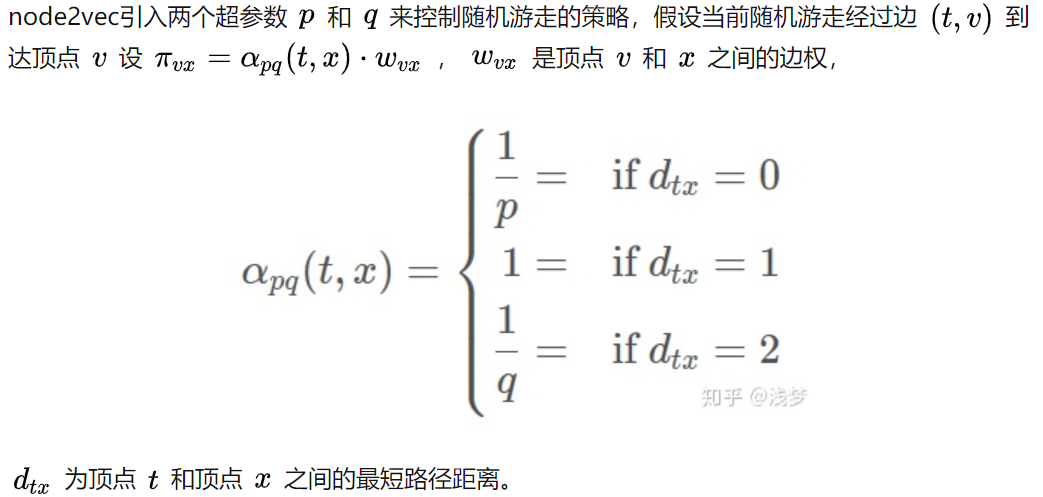
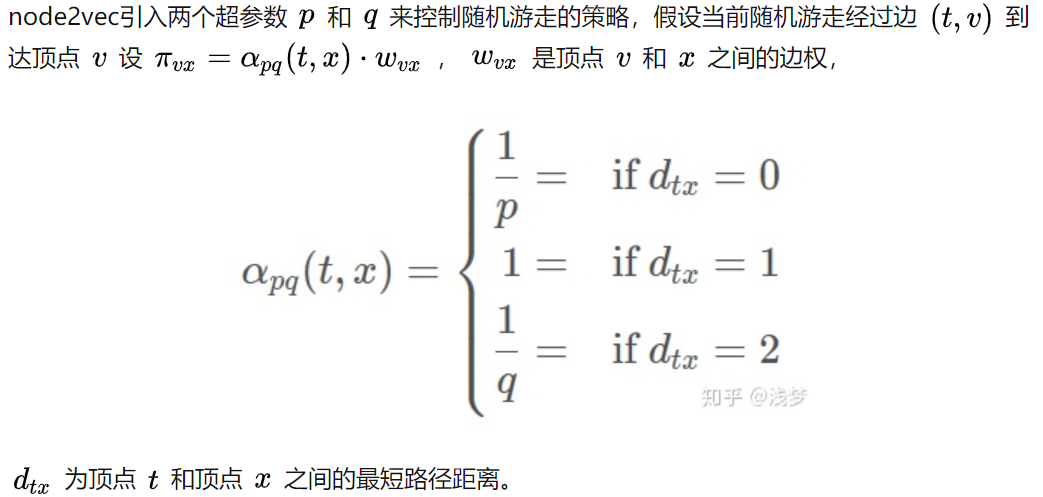
p越小更会往回走，表达同质性
q控制结构性，q越小，会更倾向往远的地方走
走p还是走q, 需要根据（t, v）和其他节点的连接情况进行决定

假设不用浅梦的代码自己落地实现的话，主要工作集中在：
1、获取行为序列，然后够着出一张图
2、deepWalk随机在图中进行游走生成序列
3、node2vec根据转移概率在图中游走生成序列
4、最后把序列放到word2vec中取生成embedding

1)原文算法在构建图的时候采用的是有向图，这个真的是有必要的吗？
skip-gram算法的训练是丢掉顺序信息的，序列 (vi, vj)和序列 (vj, vi)是等价的。
skip-gram不关心序列顺序，只是不知道有向图和无向图生成的item pair数量分布是否有差异。

2）之前在看graph embedding的时候，就在想一个问题：
为什么要把序列先转成graph，然后再随机游走，生成序列进行训练？为什么不直接拿原始序列进行训练？
直接用原始的序列，可能存在的问题是，有一些item出现频次非常高，有一些item出现频次很低，导致部分item过度训练，而另外一些item训练不足，训练结果朝着那些热门item偏移。生成graph之后，只保留了item之间的结构，而丢掉了item出现的频次信息。在做随机游走的时候，每个节点都要作为起点游走生成序列，因此每个节点都能保证一定数量的出现频次，使得所有item都能得到有效的训练。